# Parte 1 1ª Práctica: Lunar Lander con neuroevolutivos

Este trabajo ha sido realizado por Adrián Contreras Castillo y Jaime González Delgado. En este notebook se incluye la implementación del entrenamiento de percepton multilayer a partir de técnicas evolutivas. Este perceptron cuenta con una capa de entrada conformado por 8 neuronas, las variables que tiene la nave espacial del juego, una capa intermedia de 6 neuronas y una salida de 4 neuronas, las acciones que puede realizar el jugador, activar motor izquierdo, activar motor principal, activar motor derecho o no hacer nada.

### Documentación

Problemas interesantes para Aprendizaje por refuerzo
 * Gymnasium: https://gymnasium.farama.org/environments/box2d/

## Instalación

!pip install gymnasium  
!pip install gymnasium[box2d] 

## Acciones adicionales

### En macos

pip uninstall swig  
xcode-select -—install (si no se tienen ya)  
pip install swig  / sudo port install swig-python
pip install 'gymnasium[box2d]' # en zsh hay que poner las comillas  

### en Windows

Si da error, se debe a la falta de la versión correcta de Microsoft Visual C++ Build Tools, que es una dependencia de Box2D. Para solucionar este problema, puede seguir los siguientes pasos:  
 * Descargar Microsoft Visual C++ Build Tools desde https://visualstudio.microsoft.com/visual-cpp-build-tools/.
 * Dentro de la app, seleccione la opción "Herramientas de compilación de C++" para instalar.
 * Reinicie su sesión en Jupyter Notebook.
 * Ejecute nuevamente el comando !pip install gymnasium[box2d] en la línea de comandos de su notebook.

In [1]:
!pip install gymnasium

  Using cached cloudpickle-3.0.0-py3-none-any.whl.metadata (7.0 kB)
   ---------------------------------------- 0.0/953.9 kB ? eta -:--:--
   -- ------------------------------------- 61.4/953.9 kB 1.7 MB/s eta 0:00:01
   ---------------- ----------------------- 399.4/953.9 kB 6.3 MB/s eta 0:00:01
   -------------------------------- ------- 778.2/953.9 kB 7.0 MB/s eta 0:00:01
   ---------------------------------------- 953.9/953.9 kB 6.0 MB/s eta 0:00:00
Using cached cloudpickle-3.0.0-py3-none-any.whl (20 kB)


In [4]:
!pip install swig

  Using cached swig-4.2.0-py2.py3-none-win_amd64.whl.metadata (3.7 kB)
Using cached swig-4.2.0-py2.py3-none-win_amd64.whl (2.5 MB)


In [5]:
!pip install gymnasium[box2d] 

  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached pygame-2.5.2-cp39-cp39-win_amd64.whl.metadata (13 kB)
Using cached pygame-2.5.2-cp39-cp39-win_amd64.whl (10.8 MB)
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp39-cp39-win_amd64.whl size=433249 sha256=00a0d916be5b0fead7d763e50f132c8b1a264c42e3e406cdcd250e2de3aa4df4
  Stored in directory: c:\users\jaime\appdata\local\pip\cache\wheels\a4\c2\c1\076651c394f05fe60990cd85616c2d95bc1619aa113f559d7d
Successfully built box2d-py


In [1]:
# multilayer perceptron of any architecture

import numpy as np
import matplotlib.pyplot as plt

class MLP:
    '''
    Class to define Multilayer Perceptrons.
    Declare instance with MLP(layers).
    '''
    def __init__(self, layers):
        '''
        layers: a tuple with (ninputs, nhidden1, nhidden2, ... noutput)
        '''
        self.layers = layers
        self.trace = False
        self.threshold = 5.0
        self.labels = None # text for the labels [input-list, output-list]
        
        self.size = 0
        self.W = [] # list of numpy matrices
        self.b = [] # list of numpy vectors
        for i in range(len(layers)-1):
            w = np.random.rand(layers[i],layers[i+1])-0.5
            b = np.random.rand(layers[i+1])-0.5
            self.W.append(w)
            self.b.append(b)
            self.size += layers[i] * layers[i+1] + layers[i+1]
        
        self.lRMS = [] # hold all traced RMSs to draw graph
        self.laccuracy = [] # hold all traced accuracies to draw graph
        
    def sigm (self, neta):
        return 1.0 / (1.0 + np.exp(-neta))
    
    def forward (self, x): # fast forward (optimized in time, but not use to train!)
        for i in range(len(self.b)):
            net = np.dot(x,self.W[i]) + self.b[i]
            x = self.sigm(net)
        return x
            
    def to_chromosome (self):
        '''
        Convert weights and biases to a flatten list to use in AG.
        '''
        ch = []
        for w,b in zip(self.W,self.b):
            ch += w.flatten().tolist()
            ch += b.flatten().tolist()
        return ch
    
    def from_chromosome (self, ch):
        '''
        Convert a flatten list (chromosome from a GA) to internal weights and biases.
        '''
        if len(ch) != self.size:
            print(self.size)
            raise ValueError("Chromosome legnth doesn't match architecture")
        self.W = []
        self.b = []
        pos = 0
        for i in range(len(self.layers)-1): # for each layer
            to = self.layers[i]*self.layers[i+1] # number of weight
            w = np.array(ch[pos:pos+to]).reshape(self.layers[i],self.layers[i+1])
            pos += to
            to = self.layers[i+1] # number of bias
            b = np.array(ch[pos:pos+to]).reshape(self.layers[i+1])
            pos += to
            
            self.W.append(w)
            self.b.append(b)


## Funciones de evolución

En la siguiente celda, se han definido las principales funciones necesarias para crear y evolucionar los individuos. Los individuos tiene 82 cromosomas correspondientes a los pesos y bias del perceptron. Se inicializa una población que irá evolucionando a partir de los métodos de cruce y mutación implementados. La función de cruce implementada es el cruce aritmético. Y la función de mutación consiste en sumar a cada cromosoma un valor aleatorio entre -1 y 1, pero impidiendo que valor del cromosoma supere el rango establecido entre -5 y 5. También se han implementado las técnicas de torneo y de elitismo.

In [79]:
import random
import copy
from IPython.display import clear_output

rang = (-5, 5) # al no hacerlo con clases, debemos definir el rango como variable global


def create (alphabet=None, N=50): # crea y devuelve población; alphabet aquí no se usa
    return [MLP([8,6,4]).to_chromosome() for _ in range(N)]

def crossover (ind1, ind2, pcross): # devuelve el cruce (emparejamiento) de dos individuos
    if pcross < random.random():
        return (ind1, ind2)

    # se aplica cruce aritmético
    beta = random.random()
    hijo1 = [beta*ind1[i] + (1-beta)*ind2[i] for i in range(len(ind1))]
    hijo2 = [beta*ind2[i] + (1-beta)*ind1[i] for i in range(len(ind1))]
   
    return (hijo1, hijo2)


def sort_pop (pop, fit): # devuelve una tupla: la población ordenada por fitness y la lista de fitness ordenada
    fit_values = [fit(x) for x in pop]
    dict_sort = dict(zip(fit_values, pop))

    sorted_pop = [dict_sort[x] for x in sorted(fit_values)]
    sorted_fit = sorted(fit_values)

    return sorted_pop, sorted_fit

def select (pop, T): # devuelve un individuo seleccionado por torneo, devuelve una copia para evitar efectos laterales
    index_list = [random.randrange(len(pop)) for _ in range(T)]
    return copy.deepcopy(pop[min(index_list)])

def mutate (ind, pmut): # devuelve individuo mutado;
    if pmut < random.random():
        return ind

    for i in range(len(ind)):
        ind[i] += random.uniform(-1, 1)
        ind[i] = max(min(ind[i], rang[1]), rang[0])

    return ind

def evolve (pop, fit, pmut, pcross=0.7, ngen=100, T=2, trace=0, elitism=False, maximize=False, change_mut=True):
    # devuelve la población evolucionada
    # si trace > 0, muestra información cada trace generaciones
    # si elitism=True, se aplica elitismo
    # si maximize=True, se busca el máximo en lugar del mínimo
    track_fitness = []
    best = None
    best_fit = 0
    pop_size = len(pop)
    for gen in range(ngen):
        if best_fit > 200 and change_mut:
            pmut = 0.2
        newpop = []
        for i in range(pop_size//2):
            # seleccionamos dos individuos
            ind1 = select(pop, T)
            ind2 = select(pop, T)
            # los cruzamos
            hijo1, hijo2 = crossover(ind1, ind2, pcross)
            # los mutamos
            hijo1 = mutate(hijo1, pmut)
            hijo2 = mutate(hijo2, pmut)
            # los añadimos a la nueva población
            newpop.append(hijo1)
            newpop.append(hijo2)
        # elitismo
        if elitism and best != None:
            # eliminamos un individuo aleatorio
            newpop.pop(random.randrange(len(newpop)))
            # añadimos el mejor de la generación anterior
            newpop.append(best)

        # evaluamos la nueva población
        pop, fit_pop = sort_pop(newpop, fit)
        if maximize:
            pop.reverse()
            fit_pop.reverse()
        # nos quedamos con el mejor
        best = pop[0]
        best_fit = fit_pop[0]
 
        # mostramos información
        if trace > 0 and gen % trace == 0:
            clear_output()
            print("Generación: ", gen)
            print("Mejor: ", best)
            print("Fitness: ", best_fit)
            print("Max: ", np.max(fit_pop))
            
            if maximize: 
                track_fitness.append(np.max(fit_pop))
            else: 
                track_fitness.append(np.min(fit_pop))
                
            plt.plot(track_fitness)
            plt.show()
            
    return pop
    

In [59]:
# neuroevolución

# construir modelo
layer = [8,6,4]
model = MLP(layer)
ch = model.to_chromosome()
model.from_chromosome(ch)

# pasar al modelo los pesos del mejor cromosoma obtenido con neuroevolución
pop = create(N=50)

# definir política
def policy (observation, individual):
    model.from_chromosome(individual)
    s = model.forward(observation)
    action = np.argmax(s)
    return action

In [60]:
# prueba lunar lander por agente

import gymnasium as gym

env = gym.make("LunarLander-v2")

def run (individual):
    #observation, info = env.reset(seed=42)
    observation, info = env.reset()
    ite = 0
    racum = 0
    while True:
        action = policy(observation,individual)
        observation, reward, terminated, truncated, info = env.step(action)
        
        racum += reward

        if terminated or truncated:
            r = (racum+200) / 500
            return racum
    
#run()

In [62]:
def fitness(individual):
    n = 10
    r = 0
    for _ in range(n):
        r += run(individual)
    return r/n

## Función de Fitness y Comienzo de la evolución

Al estar evolucionando en un ambiente cambiante, se ha definido una función de fitness que juega 10 partidas para cada individuo obteninedo la puntuación media de esas 10 partidas. De esta forma podemos tener más seguridad que los individuos se adaptan a terrenos cambiantes. Una vez definida la función de fitness la cual se busca maximizar, ya que el objetivo es alcanzar la mayor puntuación posible, considerando que la nave aterriza cuando la puntuación es superior a 200.

En la grafica mostrada durante el entrenamiento va mostrando la evolución de la puntuación que va alcanzando el mejor individuo en cada generación. Cabe destacar el gran avance que se produce entorno a la generación 200, donde se alcanza por primera vez un puntuación media de 250. A pesar, de los buenos resultados de las individuos en estas primeras 500 generaciones, se ha decidido someter a la última población obtenida a otras 500 evoluciones con el fin de afianzar un solución que reduzca a un más los fallos en el juego. En estas últimas evoluciones se puede observar un cambio significativo, pasando de resultados medios entre 230 y 250 a resultados situados entorno a los 280 puntos. Permitiendo obtneer unos individuos al cabo de 1000 generaciones que aterriza en prácticamente la totalidad de las situaciones de juego.

Generación:  490
Mejor:  [1.7784960481499648, -1.4495235973615233, 1.0157035098907015, -0.6522398775889431, 1.6910707878268396, -0.8309677016592135, 0.16740860707190028, 0.8054327140843099, -1.05815683763582, -0.7977318541774265, -0.21475652444217258, -0.09253673202743666, -1.9479664386747038, -0.23446444428553206, 0.6583564843065672, 0.37989671362867133, 2.024714540462118, 0.6073146892901152, -0.18382356166720973, 2.5792118843596556, -1.7419180644775123, -1.5685353380960336, -2.1030308473093626, -1.8144259549773054, 2.1516345029738684, -1.0761291362001477, 0.8417543608338123, 2.4715095604154196, 1.6688822136183754, -0.4960121551451172, 1.2178476637181146, 2.001326554112204, -2.617968597579365, -0.4590151628089944, -1.8748137980468815, -0.07468108064421952, -0.2853090200271965, -0.8079195100546401, 0.027791894505108727, -0.6573932841464736, -0.48463663267384816, 1.8532609304339824, -0.10704679176040814, 3.486890913377067, -1.9827552855887307, 0.2382130216033304, 0.4336287017913819, 1.5

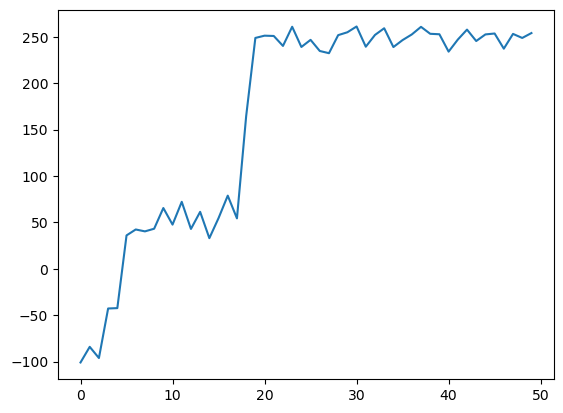

In [68]:
pop = create(N=100)
pop = evolve(pop, fitness, pmut=0.5, pcross=0.7, ngen=500, T=6, trace=10, elitism=True, maximize=True)

In [69]:
import pickle

# Aquí está tu variable
print(len(pop))

# Abre el archivo donde quieres guardar la variable
with open('gen_500.pkl', 'wb') as f:
    # Usa pickle.dump para guardar la variable en el archivo
    pickle.dump(pop, f)

100


In [72]:
with open('gen_500.pkl', 'rb') as f:
    pop2 = pickle.load(f)

print(pop2[0])

[1.7784960481400014, -1.4495235973524445, 1.0157035098745477, -0.6522398775908873, 1.6910707878110687, -0.83096770164294, 0.16740860705648428, 0.8054327140654713, -1.058156837624784, -0.7977318541929783, -0.21475652445439392, -0.0925367320150767, -1.947966438688813, -0.23446444426803115, 0.658356484308926, 0.37989671364761857, 2.024714540465692, 0.6073146892991437, -0.18382356167887573, 2.5792118843568304, -1.7419180644911756, -1.5685353380937646, -2.103030847305923, -1.8144259549650652, 2.151634502956768, -1.0761291361964216, 0.841754360836336, 2.4715095604022688, 1.6688822136329857, -0.4960121551347884, 1.2178476637399616, 2.0013265541143936, -2.6179685975802665, -0.45901516278627563, -1.8748137980595878, -0.07468108064645006, -0.28530902002176406, -0.8079195100756795, 0.02779189449373935, -0.6573932841381549, -0.48463663269231877, 1.8532609304376986, -0.10704679176929562, 3.486890913369993, -1.9827552856101327, 0.23821302160104046, 0.43362870178668167, 1.5205278066102235, 0.15107706

In [70]:
import gymnasium as gym

def run_info_2(individual, env):
    #observation, info = env.reset(seed=42)
    observation, info = env.reset()
    ite = 0
    racum = 0
    while True:
        action = policy(observation,individual)
        observation, reward, terminated, truncated, info = env.step(action)
        
        racum += reward

        str_print = "Reward: "

        if terminated or truncated:
            str_print += str(racum)
            if racum > 200:
                str_print += " (success)"
            r = (racum+200) / 500
            #print(racum, r)
            print(str_print)
            return racum

def get_ref_medio(individuo, draw=False):
    # Draw == True para ver el entorno, False para no verlo

    if draw:
        env = gym.make("LunarLander-v2", render_mode="human")
    else:
        env = gym.make("LunarLander-v2")

    N = 10
    r = []

    for _ in range(N):
        r.append(run_info_2(individuo, env))
        
    r_mean = round(np.mean(r),2)
    r_std = round(np.std(r),2)

    print(f"Refuerzo medio: {r_mean}\u00B1{r_std}")

## Resultados mejor individuo en 500 generaciones

La siguiente celda recoge los resultados de 10 partidas con el individuo de la generación 500, donde se observa que aterriza en 7 de las simulaciones, pero la media se encuentra por debajo de los 200 puntos y con una gran dispersión en los resultados.

In [78]:
get_ref_medio(pop2[0], draw=False)

Reward: 243.77521261796784 (success)
Reward: 167.81488558255052
Reward: 61.35706268749243
Reward: 283.8792990355667 (success)
Reward: 254.5203922172142 (success)
Reward: 248.7410623165187 (success)
Reward: 275.17941529919335 (success)
Reward: 255.5558209025079 (success)
Reward: -126.92021647364552
Reward: 234.23302499343876 (success)
Refuerzo medio: 189.81±122.6


Generación:  499
Mejor:  [1.8357286555871286, -1.2871596923469366, 1.4427148862006072, -1.067942694050395, 1.227124470825069, -0.3981336686645661, 0.0883329202495089, 0.9084858537655703, -1.2053240252464583, -1.142492819624883, 0.11154123604243943, -0.3650155529712934, -2.03375689019522, -0.062074655428796824, 0.14414653627099216, -0.02491185776241151, 2.0444742827444142, 0.5944290241961856, -0.4718697995004135, 2.316237267074747, -1.7385138494409267, -1.4940020467480688, -1.987963428249699, -2.0162111407446517, 2.231441321920885, -1.1998198763027241, 0.8417777375207538, 2.2840486552267603, 1.865910176780503, 0.11251991349005713, 1.2048834469912948, 2.1270109611763, -2.493620604762256, -1.0746903666854994, -1.6354814628774257, -0.32206569594811607, 0.009133374806930645, -1.410958838217427, 0.04341748320036815, -0.6171452965019152, -0.13271941657030176, 1.7739670003427677, 0.12353015921022778, 3.4555607712192127, -1.7489842524959256, 0.9720662079198408, 0.144029397715843, 2.291592774198

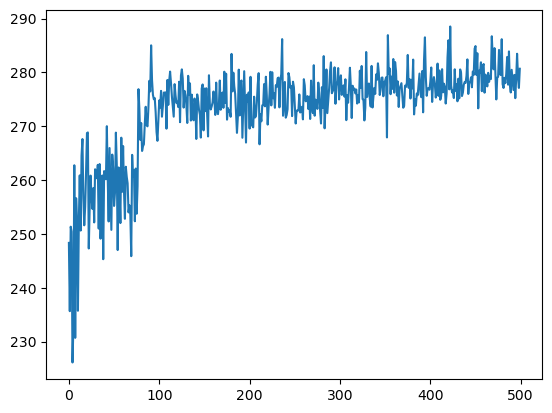

In [80]:
pop3 = evolve(pop2, fitness, pmut=0.5, pcross=0.7, ngen=500, T=6, trace=1, elitism=True, maximize=True, change_mut=False)

In [81]:
get_ref_medio(pop3[0], draw=False)

Reward: 261.2921833922592 (success)
Reward: 249.78990241481293 (success)
Reward: 271.14112549062736 (success)
Reward: 249.05394201478234 (success)
Reward: 254.20238244954504 (success)
Reward: 278.9066632908958 (success)
Reward: 272.50590150845903 (success)
Reward: 252.51178312961156 (success)
Reward: 257.647737880856 (success)
Reward: 305.93811836940483 (success)
Refuerzo medio: 265.3±16.7


In [83]:
import pickle


# Abre el archivo donde quieres guardar la variable
with open('gen_1000.pkl', 'wb') as f:
    # Usa pickle.dump para guardar la variable en el archivo
    pickle.dump(pop[0], f)

## Resultados del mejor individuo despues de 1000 generaciones

En la siguiente celda se recogen los resultados de jugar 10 partidas con el mejor individuo de la generación 1000 donde se consigue aterrizar en las 10 partidas con una puntuación media de 280 y desviación baja entre las simulaciones.

In [82]:
get_ref_medio(pop3[0], draw=False)

Reward: 297.94925485870186 (success)
Reward: 271.9546750098002 (success)
Reward: 294.2425219180188 (success)
Reward: 260.02438095356615 (success)
Reward: 293.731172434419 (success)
Reward: 282.23464617299385 (success)
Reward: 309.28776962281455 (success)
Reward: 276.9235686689187 (success)
Reward: 266.6503203654605 (success)
Reward: 250.37741205520467 (success)
Refuerzo medio: 280.34±17.62
